In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
df = pd.read_csv("credit_card_customers.csv")
df.shape

(10127, 18)

In [3]:
from sklearn.model_selection import train_test_split

# y == 1 => Customer has attrited
X = df.drop(columns=["Attrition_Flag"])
y = (df["Attrition_Flag"] == "Attrited Customer").astype(int)

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=239
)
X_train_raw.shape, X_test_raw.shape, y_train.shape, y_test.shape

((8101, 17), (2026, 17), (8101,), (2026,))

In constrast to tree-based models, here we need to scale the numerical features. I also one-hot encode all the categorical features. <br>

In [4]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_cols = [
    "Gender",
    "Education_Level",
    "Marital_Status",
    "Income_Category",
    "Card_Category",
]

numeric_cols = [
    "Customer_Age",
    "Dependent_count",
    "Months_on_book",
    "Total_Relationship_Count",
    "Months_Inactive_12_mon",
    "Contacts_Count_12_mon",
    "Credit_Limit",
    "Total_Revolving_Bal",
    "Total_Amt_Chng_Q4_Q1",
    "Total_Trans_Amt",
    "Total_Trans_Ct",
    "Total_Ct_Chng_Q4_Q1",
]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(), categorical_cols),
    ]
)

X_train = preprocess.fit_transform(X_train_raw)
X_test = preprocess.transform(X_test_raw)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8101, 35), (2026, 35), (8101,), (2026,))

Lets define the neural network model. <br>
I use dropout inbetween the layers to prevent overfitting and use the `sigmoid` activation function in the output layer, producing a single probability `P(churning)`.

In [5]:
from tensorflow.keras import layers

keras.utils.set_random_seed(239)

# I have experimented with different architectures, this one seems to work well
model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(256, activation="sigmoid"),
        layers.Dropout(0.10),
        layers.Dense(64, activation="sigmoid"),
        layers.Dropout(0.10),
        layers.Dense(1, activation="sigmoid"),
    ]
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")],
)

Lets compute the class weights to pass it into the `fit` method. This is necessary because the classes are inbalanced (we have much more existing customers than attrited ones).

In [6]:
from sklearn.utils import class_weight

cw = class_weight.compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
class_weights = {0: cw[0], 1: cw[1]}
class_weights

{0: np.float64(0.5957493749080747), 1: np.float64(3.1109831029185866)}

In [7]:
from tensorflow.keras import callbacks

early_stop = callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=25, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=64,
    validation_split=0.20,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1,
)

Epoch 1/500
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6075 - auc: 0.6473 - loss: 0.6590 - val_accuracy: 0.7835 - val_auc: 0.8773 - val_loss: 0.5046
Epoch 2/500
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.7900 - auc: 0.8699 - loss: 0.4650 - val_accuracy: 0.8168 - val_auc: 0.8920 - val_loss: 0.4212
Epoch 3/500
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.8189 - auc: 0.8923 - loss: 0.4144 - val_accuracy: 0.8390 - val_auc: 0.9018 - val_loss: 0.3775
Epoch 4/500
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.8377 - auc: 0.9080 - loss: 0.3848 - val_accuracy: 0.8495 - val_auc: 0.9094 - val_loss: 0.3607
Epoch 5/500
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8325 - auc: 0.9112 - loss: 0.3789 - val_accuracy: 0.8581 - val_auc: 0.9139 - val_loss: 0.3501
Epoch 6/500
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.8426 - auc: 0.9174 - loss: 0.3666 - val_accuracy: 0.8655 - val_auc: 0.9164 - val_loss: 0.3327
Epoch 7/500
102/102 ━━━━━━

Lets plot the training vs validation loss over epochs. <br>

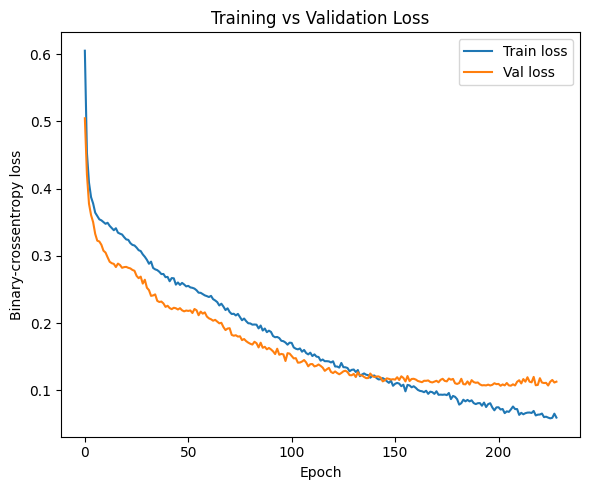

In [8]:
plt.figure(figsize=(6, 5))
plt.plot(history.history["loss"], label="Train loss")
plt.plot(history.history["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Binary-crossentropy loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.savefig("img/nn/loss.png", dpi=300)
plt.show()

Loss: 0.1063  Accuracy: 0.9600  AUC: 0.9884
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step
Accuracy : 0.960
Precision: 0.865
Recall   : 0.889
F1-score : 0.877
ROC-AUC  : 0.990


<Figure size 400x400 with 0 Axes>

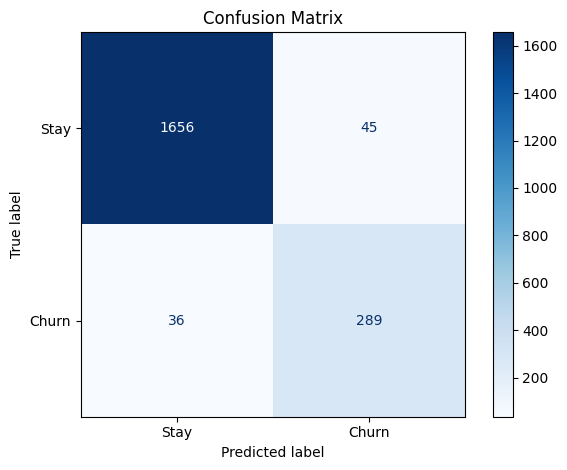

In [9]:
from sklearn.metrics import *

test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {test_loss:.4f}  Accuracy: {test_acc:.4f}  AUC: {test_auc:.4f}")

y_pred_proba = model.predict(X_test).ravel()
y_pred = (y_pred_proba >= 0.50).astype(int)

print(f"Accuracy : {accuracy_score(y_test, y_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred):.3f}")
print(f"F1-score : {f1_score(y_test, y_pred):.3f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_pred_proba):.3f}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=["Stay", "Churn"], cmap="Blues"
)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("img/nn/default_confusion_matrix.png", dpi=300)
plt.show()

Neural network model has better recall (and f1-score) than the tree-based models when a default threshold is used. In the confusion matrix, the number of falsely predicted to stay (who really churned) is lower than in the tree-based models, but the number of falsely predicted to churn is higher. Is that better or not depends on the end-goal. <br>
In the trees notebook I explain why I think recall is more important to us in this task. So with default threshold this model is better. We will choose the best threshold below. <br>

Let us first plot the ROC curve. <br>
The ROC AUC is nearly the same as in tree-based models (0.990 vs 0.991). <br>

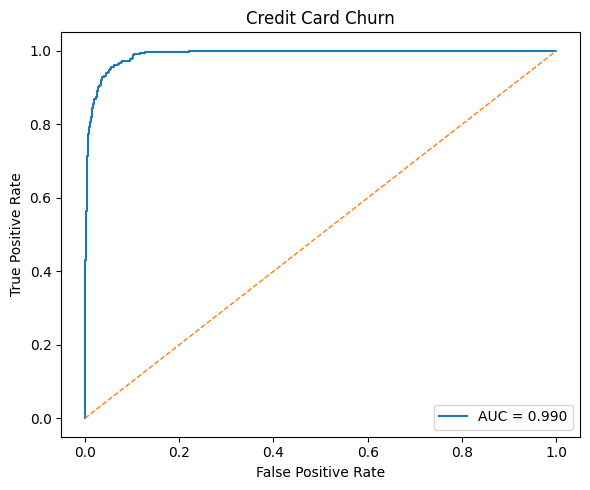

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba):.3f}")
plt.plot([0, 1], [0, 1], "--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Credit Card Churn")
plt.legend()
plt.tight_layout()
plt.savefig("img/nn/roc_curve.png", dpi=300)
plt.show()

Using the same logic as in the trees notebook, lets tweak the threshold to increase recall. <br>

64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 331us/step
Best threshold (max-F2): 0.160
Accuracy : 0.946
Precision: 0.764
Recall   : 0.957
F1-score : 0.850
F2-score : 0.911


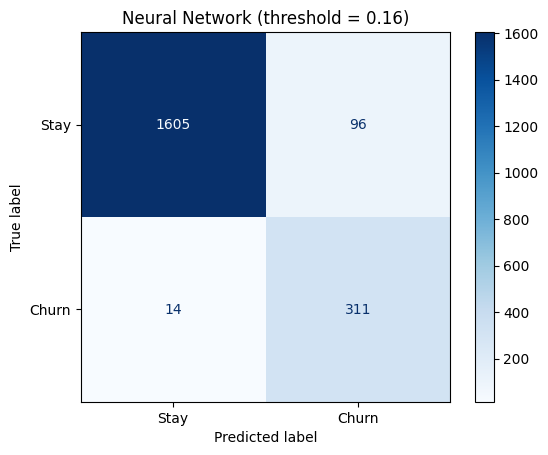

In [11]:
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, fbeta_score

y_pred_proba = model.predict(X_test).ravel()

prec, rec, thr = precision_recall_curve(y_test, y_pred_proba)
beta = 2
f2 = (1 + beta**2) * prec[:-1] * rec[:-1] / (beta**2 * prec[:-1] + rec[:-1])

best_thr = thr[int(np.argmax(f2))]

y_pred_opt = (y_pred_proba >= best_thr).astype(int)
print(f"Best threshold (max-F{beta}): {best_thr:.3f}")
print(f"Accuracy : {accuracy_score(y_test, y_pred_opt):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_opt):.3f}")
print(f"Recall   : {recall_score(y_test, y_pred_opt):.3f}")
print(f"F1-score : {f1_score(y_test, y_pred_opt):.3f}")
print(f"F{beta}-score : {fbeta_score(y_test, y_pred_opt, beta=beta):.3f}")

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_opt, display_labels=["Stay", "Churn"], cmap="Blues"
)
plt.title(f"Neural Network (threshold = {best_thr:.2f})")
plt.savefig("img/nn/better_confusion_matrix.png", dpi=300)
plt.show()

The tweaked model is slightly worse than the random forest model, it labeled just 25 more clients as falsely churning.

It is much harder to interpret the neural network model, thats why I did it using the tree-based models (see `trees.ipynb`).